In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib import cm
import seaborn as sns
import numpy as np
import pandas as pd
import string
import re, calendar, time, datetime
from datetime import datetime
from collections import Counter
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
import math          #for basic maths operations
import seaborn as sns #for making plots
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

C:\Users\a1381\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Train

In [2]:
# Read in the processed data
train = pd.read_csv('New.csv')

In [57]:
def haversine_(lat1, lng1, lat2, lng2):
    """
    function to calculate haversine distance between two co-ordinates
    input: array of lat and lng
    output: array of distance
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

## Speed

In [3]:
# Speed calculated by external data (osrm)
train['fast_speed'] = train.total_distance / (train.total_travel_time + 0.1)

## store_and_fwd_flag

Convert the string into 1, 0

In [36]:
train['store_and_fwd_flag'] = 1*(train.store_and_fwd_flag == 'Y')

## Holiday / Weekend / Pickup_time

In [4]:
holiday = pd.read_csv('NYC_2016Holidays.csv',sep=';')
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')

In [5]:
holiday.head()

,Day,Date,Holiday
0,Friday,January 01 2016,New Years Day
1,Monday,January 18 2016,Martin Luther King Jr. Day
2,Friday,February 12 2016,Lincoln's Birthday
3,Monday,February 15 2016,Presidents' Day
4,Sunday,May 08 2016,Mother's Day


In [6]:
holiday['Date'] = pd.to_datetime(holiday['Date'])
holiday['pick_month'] = holiday['Date'].dt.month
holiday['day'] = holiday['Date'].dt.day
holiday['is_holiday'] = 1

In [7]:
train = pd.merge(train, holiday[['pick_month', 'day', 'is_holiday']], how='left', on=['pick_month', 'day'])
train['is_holiday'][train['is_holiday'].isnull()] = 0
train.is_holiday.value_counts()

0.0    1407522
1.0      51122
Name: is_holiday, dtype: int64

In [8]:
weekend_index = train[(train.day_of_week == 5) | (train.day_of_week == 6)].index
train['is_weekend'] = 0
train.ix[weekend_index, 'is_weekend'] = 1
train.is_weekend.value_counts()

0    1042410
1     416234
Name: is_weekend, dtype: int64

In [9]:
train['pickup_time'] = train.hour + train.minute/60

## Shortest path and time

In [10]:
train_fr_1 = pd.read_csv('C:/Users/a1381/Desktop/UIUC/Python/Project/Taxi/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv')
train_fr_2 = pd.read_csv('C:/Users/a1381/Desktop/UIUC/Python/Project/Taxi/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv')
train_fr = pd.concat([train_fr_1, train_fr_2])

In [11]:
train_fr['step_direction'] = train_fr['step_direction'].astype('str')
train = pd.merge(train, train_fr[['id', 'step_direction']], how='left', on='id')
train['right_count'] = train['step_direction'].str.count('right')
train['left_count'] = train['step_direction'].str.count('left')
del train['step_direction']

## Weather

Extract features Precipitation, Snow, Visibility, Temperature

In [12]:
weather = pd.read_csv('NYC_Metars.csv', parse_dates=['Time'])
weather.head(3)

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast


In [13]:
weather['snow']= 1*(weather.Events=='Snow') + 1*(weather.Events=='Fog\n\t,\nSnow')
weather['year'] = weather['Time'].dt.year
weather['pick_month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hour'] = weather['Time'].dt.hour
weather = weather[weather['year'] == 2016][['pick_month','day','hour','Temp.','Precip','snow','Visibility']]

In [14]:
weather.head()

,pick_month,day,hour,Temp.,Precip,snow,Visibility
22,1,1,0,5.6,0.0,0,16.1
23,1,1,1,5.6,0.0,0,16.1
24,1,1,2,5.6,0.0,0,16.1
25,1,1,3,5.0,0.0,0,16.1
26,1,1,4,5.0,0.0,0,16.1


In [15]:
train = pd.merge(left=train, right=weather, left_on = ['pick_month', 'day', 'hour'], right_on = ['pick_month', 'day', 'hour'], how = 'left')

## Cluster

Cluster the data by pickup coordinate and dropoff coordinate, we set k as 500 in order to catch the information of street or small region

In [16]:
from sklearn.cluster import MiniBatchKMeans, KMeans
# get lon & lat clustering for following avg location speed calculation
def get_clustering(df):
    # turn into this form [[lat, lon], [lat, lon], ....]
    coords = np.vstack((df[['pickup_latitude', 'pickup_longitude']].values,
                        df[['dropoff_latitude', 'dropoff_longitude']].values,
                        df[['mid_lat', 'mid_lon']].values))
    df_ = df.copy()
    kmeans = MiniBatchKMeans(n_clusters=500, batch_size=5000).fit(coords)
    df_.loc[:, 'pickup_cluster'] = kmeans.predict(df_[['pickup_latitude', 'pickup_longitude']])
    df_.loc[:, 'mid_cluster'] = kmeans.predict(df_[['mid_lat', 'mid_lon']])
    df_.loc[:, 'dropoff_cluster'] = kmeans.predict(df_[['dropoff_latitude', 'dropoff_longitude']])
    return df_, kmeans

In [17]:
# Find the mid point
train['mid_lat'] = (train.pickup_latitude + train.dropoff_latitude) / 2.
train['mid_lon'] = (train.pickup_longitude + train.dropoff_longitude) / 2.

# Get the cluster by pickup point, mid point and dropoff point
train, kmeans = get_clustering(train)

### Pickup and dropoff cluster

Find the trip count in each cluster

In [18]:
pick_cluster_count = train.groupby(['pickup_cluster', 'hour']).agg(['size'])['id'].reset_index()
drop_cluster_count = train.groupby(['dropoff_cluster', 'hour']).agg(['size'])['id'].reset_index()
pick_cluster_count = pick_cluster_count.rename(columns = {'size':'pick_cluster_count'})
drop_cluster_count = drop_cluster_count.rename(columns = {'size':'drop_cluster_count'})
train = pd.merge(left=train, right=pick_cluster_count, how='left', left_on=['pickup_cluster', 'hour'], right_on = ['pickup_cluster', 'hour'])
train = pd.merge(left=train, right=drop_cluster_count, how='left', left_on=['dropoff_cluster', 'hour'], right_on = ['dropoff_cluster', 'hour'])

Find the mean of speed in each cluster and in each hour

In [19]:
pick_cluster_speed = train.groupby(['pickup_cluster', 'hour']).agg(['mean'])['fast_speed'].reset_index()
drop_cluster_speed = train.groupby(['dropoff_cluster', 'hour']).agg(['mean'])['fast_speed'].reset_index()
pick_cluster_speed = pick_cluster_speed.rename(columns = {'mean':'pick_cluster_speed'})
drop_cluster_speed = drop_cluster_speed.rename(columns = {'mean':'drop_cluster_speed'})
train = pd.merge(left=train, right=pick_cluster_speed, how='left', left_on=['pickup_cluster', 'hour'], right_on = ['pickup_cluster', 'hour'])
train = pd.merge(left=train, right=drop_cluster_speed, how='left', left_on=['dropoff_cluster', 'hour'], right_on = ['dropoff_cluster', 'hour'])

Find the median of Bearing in each cluster and in each hour

In [20]:
pick_cluster_bearing = train.groupby(['pickup_cluster', 'hour']).agg(['median'])['bearing'].reset_index()
drop_cluster_bearing = train.groupby(['dropoff_cluster', 'hour']).agg(['median'])['bearing'].reset_index()
pick_cluster_bearing = pick_cluster_bearing.rename(columns = {'median':'pick_cluster_bearing'})
drop_cluster_bearing = drop_cluster_bearing.rename(columns = {'median':'drop_cluster_bearing'})
train = pd.merge(left=train, right=pick_cluster_bearing, how='left', left_on=['pickup_cluster', 'hour'], right_on = ['pickup_cluster', 'hour'])
train = pd.merge(left=train, right=drop_cluster_bearing, how='left', left_on=['dropoff_cluster', 'hour'], right_on = ['dropoff_cluster', 'hour'])

Finding the number of steps in each cluster

In [21]:
pick_cluster_steps = train.groupby(['pickup_cluster']).agg(['mean'])['number_of_steps'].reset_index()
drop_cluster_steps = train.groupby(['dropoff_cluster']).agg(['mean'])['number_of_steps'].reset_index()
pick_cluster_steps = pick_cluster_steps.rename(columns = {'mean':'pick_cluster_steps'})
drop_cluster_steps = drop_cluster_steps.rename(columns = {'mean':'drop_cluster_steps'})
train = pd.merge(left=train, right=pick_cluster_steps, how='left', on='pickup_cluster')
train = pd.merge(left=train, right=drop_cluster_steps, how='left', on='dropoff_cluster')

Trip duration based on pickup and dropoff cluster

In [22]:
train['total_travel_time'] = np.log(train['total_travel_time']+1)
pick_drop_cluster_trip_duration = train.groupby(['pickup_cluster', 'dropoff_cluster', 'hour']).agg(['mean'])['total_travel_time'].reset_index()
pick_drop_cluster_trip_duration = pick_drop_cluster_trip_duration.rename(columns = {'mean':'pick_drop_cluster_trip_duration_hour'})
train = pd.merge(left=train, right=pick_drop_cluster_trip_duration, how='left', left_on=['pickup_cluster', 'dropoff_cluster', 'hour'], right_on = ['pickup_cluster', 'dropoff_cluster', 'hour'])

In [23]:
pick_drop_cluster_trip_duration = train.groupby(['pickup_cluster', 'dropoff_cluster', 'day_of_week']).agg(['mean'])['total_travel_time'].reset_index()
pick_drop_cluster_trip_duration = pick_drop_cluster_trip_duration.rename(columns = {'mean':'pick_drop_cluster_trip_duration_weekday'})
train = pd.merge(left=train, right=pick_drop_cluster_trip_duration, how='left', left_on=['pickup_cluster', 'dropoff_cluster', 'day_of_week'], right_on = ['pickup_cluster', 'dropoff_cluster', 'day_of_week'])

Trip distance based on pickup and dropoff cluster

In [24]:
pick_drop_cluster_trip_distance = train.groupby(['pickup_cluster', 'dropoff_cluster']).agg(['mean'])['total_distance'].reset_index()
pick_drop_cluster_trip_distance = pick_drop_cluster_trip_distance.rename(columns = {'mean':'pick_drop_cluster_trip_distance'})
train = pd.merge(left=train, right=pick_drop_cluster_trip_distance, how='left', left_on=['pickup_cluster', 'dropoff_cluster'], right_on = ['pickup_cluster', 'dropoff_cluster'])

Avg speed based on pickup and dropmoff cluster

In [25]:
pick_drop_cluster_fast_speed = train.groupby(['pickup_cluster', 'dropoff_cluster', 'hour']).agg(['mean'])['fast_speed'].reset_index()
pick_drop_cluster_fast_speed = pick_drop_cluster_fast_speed.rename(columns = {'mean':'pick_drop_cluster_fast_speed_hour'})
train = pd.merge(left=train, right=pick_drop_cluster_fast_speed, how='left', left_on=['pickup_cluster', 'dropoff_cluster', 'hour'], right_on = ['pickup_cluster', 'dropoff_cluster', 'hour'])

In [26]:
pick_drop_cluster_fast_speed = train.groupby(['pickup_cluster', 'dropoff_cluster', 'day_of_week']).agg(['mean'])['fast_speed'].reset_index()
pick_drop_cluster_fast_speed = pick_drop_cluster_fast_speed.rename(columns = {'mean':'pick_drop_cluster_fast_speed_weekday'})
train = pd.merge(left=train, right=pick_drop_cluster_fast_speed, how='left', left_on=['pickup_cluster', 'dropoff_cluster', 'day_of_week'], right_on = ['pickup_cluster', 'dropoff_cluster', 'day_of_week'])

Trip count based on pickup and dropmoff cluster

In [27]:
pick_drop_cluster_trip_count = train.groupby(['pickup_cluster', 'dropoff_cluster', 'hour']).agg(['count'])['id'].reset_index()
pick_drop_cluster_trip_count = pick_drop_cluster_trip_count.rename(columns = {'count':'pick_drop_cluster_trip_count_hour'})
train = pd.merge(left=train, right=pick_drop_cluster_trip_count, how='left', left_on=['pickup_cluster', 'dropoff_cluster', 'hour'], right_on = ['pickup_cluster', 'dropoff_cluster', 'hour'])

In [28]:
pick_drop_cluster_trip_count = train.groupby(['pickup_cluster', 'dropoff_cluster', 'day_of_week']).agg(['count'])['id'].reset_index()
pick_drop_cluster_trip_count = pick_drop_cluster_trip_count.rename(columns = {'count':'pick_drop_cluster_trip_count_weekday'})
train = pd.merge(left=train, right=pick_drop_cluster_trip_count, how='left', left_on=['pickup_cluster', 'dropoff_cluster', 'day_of_week'], right_on = ['pickup_cluster', 'dropoff_cluster', 'day_of_week'])

### Midpoint cluster

The mid point is the point between the starting point and the destination

In [29]:
mid_cluster_count = train.groupby(['mid_cluster', 'hour']).agg(['size'])['id'].reset_index()
mid_cluster_count = mid_cluster_count.rename(columns = {'size':'mid_cluster_count'})
train = pd.merge(left=train, right=mid_cluster_count, how='left', left_on=['mid_cluster', 'hour'], right_on = ['mid_cluster', 'hour'])

In [30]:
mid_cluster_speed = train.groupby(['mid_cluster', 'hour']).agg(['mean'])['fast_speed'].reset_index()
mid_cluster_speed = mid_cluster_speed.rename(columns = {'mean':'mid_cluster_speed'})
train = pd.merge(left=train, right=mid_cluster_speed, how='left', left_on=['mid_cluster', 'hour'], right_on = ['mid_cluster', 'hour'])

In [31]:
mid_cluster_bearing = train.groupby(['mid_cluster', 'hour']).agg(['median'])['bearing'].reset_index()
mid_cluster_bearing = mid_cluster_bearing.rename(columns = {'median':'mid_cluster_bearing'})
train = pd.merge(left=train, right=mid_cluster_bearing, how='left', left_on=['mid_cluster', 'hour'], right_on = ['mid_cluster', 'hour'])

In [32]:
mid_cluster_bearing = train.groupby(['mid_cluster']).agg(['median'])['bearing'].reset_index()
mid_cluster_bearing = mid_cluster_bearing.rename(columns = {'median':'mid_cluster_bearing'})
train = pd.merge(left=train, right=mid_cluster_bearing, how='left', left_on=['mid_cluster'], right_on = ['mid_cluster'])

In [33]:
mid_cluster_steps = train.groupby(['mid_cluster']).agg(['mean'])['number_of_steps'].reset_index()
mid_cluster_steps = mid_cluster_steps.rename(columns = {'mean':'mid_cluster_steps'})
train = pd.merge(left=train, right=mid_cluster_steps, how='left', on='mid_cluster')

In [34]:
mid_cluster_trip_duration = train.groupby(['mid_cluster', 'hour']).agg(['mean'])['total_travel_time'].reset_index()
mid_cluster_trip_duration = mid_cluster_trip_duration.rename(columns = {'mean':'mid_cluster_trip_duration'})
train = pd.merge(left=train, right=mid_cluster_trip_duration, how='left', left_on=['mid_cluster', 'hour'], right_on = ['mid_cluster', 'hour'])

In [35]:
mid_cluster_trip_distance = train.groupby(['mid_cluster']).agg(['mean'])['total_distance'].reset_index()
mid_cluster_trip_distance = mid_cluster_trip_distance.rename(columns = {'mean':'mid_cluster_trip_distance'})
train = pd.merge(left=train, right=mid_cluster_trip_distance, how='left', on='mid_cluster')

In [58]:
train['pca_manh'] = abs(train.pickup_pca0 - train.dropoff_pca0) + abs(train.pickup_pca1 - train.dropoff_pca1)
train['pca_manh_'] = (train.pickup_pca0 - train.dropoff_pca0) + (train.pickup_pca1 - train.dropoff_pca1)
train['manhtn_pick_drop_'] = (train.pickup_latitude - train.dropoff_latitude) + (train.pickup_longitude - train.dropoff_longitude)
train['pca_haver'] = haversine_(train.pickup_pca0, train.pickup_pca1, train.dropoff_pca0, train.dropoff_pca1)

## is_morning

In [80]:
train['is_morning'] = 0
train.loc[(train.pickup_time<6.5) & (train.pickup_time>5.5), 'is_morning'] = 1

## ------------------------------------------------------------------------------------------------------------------------------------

# Test

In [40]:
# Read in processed test data
test = pd.read_csv('final_test_2.csv')

In [41]:
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
test.loc[:, 'year'] = test['pickup_datetime'].dt.year
test.loc[:, 'day'] = test['pickup_datetime'].dt.day
test.loc[:, 'minute'] = test['pickup_datetime'].dt.minute

In [42]:
# Speed calculated by external data (osrm)
test['fast_speed'] = test.total_distance / (test.total_travel_time + 0.1)

## Cluster

In [43]:
# Delete the useless features
del test['pick_cluster_count']
del test['drop_cluster_count']
del test['pick_cluster_speed']
del test['drop_cluster_speed']
del test['pick_cluster_bearing']
del test['drop_cluster_bearing']
del test['pickup_cluster']
del test['dropoff_cluster']

In [44]:
# Find the mid point
test['mid_lat'] = (test.pickup_latitude + test.dropoff_latitude) / 2.
test['mid_lon'] = (test.pickup_longitude + test.dropoff_longitude) / 2.

# Get the cluster by pickup point, mid point and dropoff point
test, kmeans = get_clustering(test)

### Pickup and dropoff cluster

Engineer the new features like we did in train data

In [45]:
pick_cluster_count = test.groupby(['pickup_cluster', 'hour']).agg(['size'])['id'].reset_index()
drop_cluster_count = test.groupby(['dropoff_cluster', 'hour']).agg(['size'])['id'].reset_index()
pick_cluster_count = pick_cluster_count.rename(columns = {'size':'pick_cluster_count'})
drop_cluster_count = drop_cluster_count.rename(columns = {'size':'drop_cluster_count'})
test = pd.merge(left=test, right=pick_cluster_count, left_on=['pickup_cluster', 'hour'], right_on = ['pickup_cluster', 'hour'])
test = pd.merge(left=test, right=drop_cluster_count, left_on=['dropoff_cluster', 'hour'], right_on = ['dropoff_cluster', 'hour'])

pick_cluster_bearing = test.groupby(['pickup_cluster', 'hour']).agg(['median'])['bearing'].reset_index()
drop_cluster_bearing = test.groupby(['dropoff_cluster', 'hour']).agg(['median'])['bearing'].reset_index()
pick_cluster_bearing = pick_cluster_bearing.rename(columns = {'median':'pick_cluster_bearing'})
drop_cluster_bearing = drop_cluster_bearing.rename(columns = {'median':'drop_cluster_bearing'})
test = pd.merge(left=test, right=pick_cluster_bearing, how='left', left_on=['pickup_cluster', 'hour'], right_on = ['pickup_cluster', 'hour'])
test = pd.merge(left=test, right=drop_cluster_bearing, how='left', left_on=['dropoff_cluster', 'hour'], right_on = ['dropoff_cluster', 'hour'])

pick_cluster_speed = test.groupby(['pickup_cluster', 'hour']).agg(['mean'])['fast_speed'].reset_index()
drop_cluster_speed = test.groupby(['dropoff_cluster', 'hour']).agg(['mean'])['fast_speed'].reset_index()
pick_cluster_speed = pick_cluster_speed.rename(columns = {'mean':'pick_cluster_speed'})
drop_cluster_speed = drop_cluster_speed.rename(columns = {'mean':'drop_cluster_speed'})
test = pd.merge(left=test, right=pick_cluster_speed, how='left', left_on=['pickup_cluster', 'hour'], right_on = ['pickup_cluster', 'hour'])
test = pd.merge(left=test, right=drop_cluster_speed, how='left', left_on=['dropoff_cluster', 'hour'], right_on = ['dropoff_cluster', 'hour'])

pick_cluster_steps = test.groupby(['pickup_cluster']).agg(['mean'])['number_of_steps'].reset_index()
drop_cluster_steps = test.groupby(['dropoff_cluster']).agg(['mean'])['number_of_steps'].reset_index()
pick_cluster_steps = pick_cluster_steps.rename(columns = {'mean':'pick_cluster_steps'})
drop_cluster_steps = drop_cluster_steps.rename(columns = {'mean':'drop_cluster_steps'})
test = pd.merge(left=test, right=pick_cluster_steps, how='left', on='pickup_cluster')
test = pd.merge(left=test, right=drop_cluster_steps, how='left', on='dropoff_cluster')


test['total_travel_time'] = np.log(test['total_travel_time']+1)
pick_drop_cluster_trip_duration = test.groupby(['pickup_cluster', 'dropoff_cluster', 'hour']).agg(['mean'])['total_travel_time'].reset_index()
pick_drop_cluster_trip_duration = pick_drop_cluster_trip_duration.rename(columns = {'mean':'pick_drop_cluster_trip_duration_hour'})
test = pd.merge(left=test, right=pick_drop_cluster_trip_duration, how='left', left_on=['pickup_cluster', 'dropoff_cluster', 'hour'], right_on = ['pickup_cluster', 'dropoff_cluster', 'hour'])

pick_drop_cluster_trip_duration = test.groupby(['pickup_cluster', 'dropoff_cluster', 'day_of_week']).agg(['mean'])['total_travel_time'].reset_index()
pick_drop_cluster_trip_duration = pick_drop_cluster_trip_duration.rename(columns = {'mean':'pick_drop_cluster_trip_duration_weekday'})
test = pd.merge(left=test, right=pick_drop_cluster_trip_duration, how='left', left_on=['pickup_cluster', 'dropoff_cluster', 'day_of_week'], right_on = ['pickup_cluster', 'dropoff_cluster', 'day_of_week'])


pick_drop_cluster_trip_distance = test.groupby(['pickup_cluster', 'dropoff_cluster']).agg(['mean'])['total_distance'].reset_index()
pick_drop_cluster_trip_distance = pick_drop_cluster_trip_distance.rename(columns = {'mean':'pick_drop_cluster_trip_distance'})
test = pd.merge(left=test, right=pick_drop_cluster_trip_distance, how='left', left_on=['pickup_cluster', 'dropoff_cluster'], right_on = ['pickup_cluster', 'dropoff_cluster'])


pick_drop_cluster_fast_speed = test.groupby(['pickup_cluster', 'dropoff_cluster', 'hour']).agg(['mean'])['fast_speed'].reset_index()
pick_drop_cluster_fast_speed = pick_drop_cluster_fast_speed.rename(columns = {'mean':'pick_drop_cluster_fast_speed_hour'})
test = pd.merge(left=test, right=pick_drop_cluster_fast_speed, how='left', left_on=['pickup_cluster', 'dropoff_cluster', 'hour'], right_on = ['pickup_cluster', 'dropoff_cluster', 'hour'])

pick_drop_cluster_fast_speed = test.groupby(['pickup_cluster', 'dropoff_cluster', 'day_of_week']).agg(['mean'])['fast_speed'].reset_index()
pick_drop_cluster_fast_speed = pick_drop_cluster_fast_speed.rename(columns = {'mean':'pick_drop_cluster_fast_speed_weekday'})
test = pd.merge(left=test, right=pick_drop_cluster_fast_speed, how='left', left_on=['pickup_cluster', 'dropoff_cluster', 'day_of_week'], right_on = ['pickup_cluster', 'dropoff_cluster', 'day_of_week'])


pick_drop_cluster_trip_count = test.groupby(['pickup_cluster', 'dropoff_cluster', 'hour']).agg(['count'])['id'].reset_index()
pick_drop_cluster_trip_count = pick_drop_cluster_trip_count.rename(columns = {'count':'pick_drop_cluster_trip_count_hour'})
test = pd.merge(left=test, right=pick_drop_cluster_trip_count, how='left', left_on=['pickup_cluster', 'dropoff_cluster', 'hour'], right_on = ['pickup_cluster', 'dropoff_cluster', 'hour'])

pick_drop_cluster_trip_count = test.groupby(['pickup_cluster', 'dropoff_cluster', 'day_of_week']).agg(['count'])['id'].reset_index()
pick_drop_cluster_trip_count = pick_drop_cluster_trip_count.rename(columns = {'count':'pick_drop_cluster_trip_count_weekday'})
test = pd.merge(left=test, right=pick_drop_cluster_trip_count, how='left', left_on=['pickup_cluster', 'dropoff_cluster', 'day_of_week'], right_on = ['pickup_cluster', 'dropoff_cluster', 'day_of_week'])

### Mid point cluster

In [46]:
mid_cluster_count = test.groupby(['mid_cluster', 'hour']).agg(['size'])['id'].reset_index()
mid_cluster_count = mid_cluster_count.rename(columns = {'size':'mid_cluster_count'})
test = pd.merge(left=test, right=mid_cluster_count, how='left', left_on=['mid_cluster', 'hour'], right_on = ['mid_cluster', 'hour'])

mid_cluster_speed = test.groupby(['mid_cluster', 'hour']).agg(['mean'])['fast_speed'].reset_index()
mid_cluster_speed = mid_cluster_speed.rename(columns = {'mean':'mid_cluster_speed'})
test = pd.merge(left=test, right=mid_cluster_speed, how='left', left_on=['mid_cluster', 'hour'], right_on = ['mid_cluster', 'hour'])

mid_cluster_bearing = test.groupby(['mid_cluster', 'hour']).agg(['median'])['bearing'].reset_index()
mid_cluster_bearing = mid_cluster_bearing.rename(columns = {'median':'mid_cluster_bearing'})
test = pd.merge(left=test, right=mid_cluster_bearing, how='left', left_on=['mid_cluster', 'hour'], right_on = ['mid_cluster', 'hour'])

mid_cluster_steps = test.groupby(['mid_cluster']).agg(['mean'])['number_of_steps'].reset_index()
mid_cluster_steps = mid_cluster_steps.rename(columns = {'mean':'mid_cluster_steps'})
test = pd.merge(left=test, right=mid_cluster_steps, how='left', on='mid_cluster')

mid_cluster_trip_duration = test.groupby(['mid_cluster', 'hour']).agg(['mean'])['total_travel_time'].reset_index()
mid_cluster_trip_duration = mid_cluster_trip_duration.rename(columns = {'mean':'mid_cluster_trip_duration'})
test = pd.merge(left=test, right=mid_cluster_trip_duration, how='left', left_on=['mid_cluster', 'hour'], right_on = ['mid_cluster', 'hour'])

mid_cluster_trip_distance = test.groupby(['mid_cluster']).agg(['mean'])['total_distance'].reset_index()
mid_cluster_trip_distance = mid_cluster_trip_distance.rename(columns = {'mean':'mid_cluster_trip_distance'})
test = pd.merge(left=test, right=mid_cluster_trip_distance, how='left', on='mid_cluster')

In [59]:
test['pca_manh'] = abs(test.pickup_pca0 - test.dropoff_pca0) + abs(test.pickup_pca1 - test.dropoff_pca1)
test['pca_manh_'] = (test.pickup_pca0 - test.dropoff_pca0) + (test.pickup_pca1 - test.dropoff_pca1)
test['manhtn_pick_drop_'] = (test.pickup_latitude - test.dropoff_latitude) + (test.pickup_longitude - test.dropoff_longitude)
test['pca_haver'] = haversine_(test.pickup_pca0, test.pickup_pca1, test.dropoff_pca0, test.dropoff_pca1)

## Shortest path and time

In [47]:
osrm_test = pd.read_csv('C:/Users/a1381/Desktop/UIUC/Python/Project/Taxi/new-york-city-taxi-with-osrm/fastest_routes_test.csv')

In [48]:
test = pd.merge(test, osrm_test[['id', 'step_direction']], how='left', on='id')
test['right_count'] = test['step_direction'].str.count('right')
test['left_count'] = test['step_direction'].str.count('left')
del test['step_direction']

## Holiday / Weekend / Pickup_time

In [49]:
holiday.head()

,Day,Date,Holiday,pick_month,day,is_holiday
0,Friday,2016-01-01,New Years Day,1,1,1
1,Monday,2016-01-18,Martin Luther King Jr. Day,1,18,1
2,Friday,2016-02-12,Lincoln's Birthday,2,12,1
3,Monday,2016-02-15,Presidents' Day,2,15,1
4,Sunday,2016-05-08,Mother's Day,5,8,1


In [50]:
test = pd.merge(test, holiday[['pick_month', 'day', 'is_holiday']], how='left', on=['pick_month', 'day'])
test['is_holiday'][test['is_holiday'].isnull()] = 0
test.is_holiday.value_counts()

0.0    603252
1.0     21882
Name: is_holiday, dtype: int64

In [51]:
weekend_index = test[(test.day_of_week == 5) | (test.day_of_week == 6)].index
test['is_weekend'] = 0
test.ix[weekend_index, 'is_weekend'] = 1
test.is_weekend.value_counts()

0    447314
1    177820
Name: is_weekend, dtype: int64

In [52]:
test['pickup_time'] = test.hour + test.minute/60

## Weather

In [53]:
test = pd.merge(test, weather, on = ['pick_month', 'day', 'hour'], how = 'left')

## store_and_fwd_flag

In [54]:
test['store_and_fwd_flag'] = 1*(test.store_and_fwd_flag == 'Y')

## is_morning

In [85]:
test['is_morning'] = 0
test.loc[(test.pickup_time<6.5) & (test.pickup_time>5.5), 'is_morning'] = 1

## ------------------------------------------------------------------------------------------------------------------------------------

# Train the model

Select columns

In [96]:
cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',
       'trip_duration', 'total_distance', 'total_travel_time',
       'number_of_steps', 'hour', 'week_of_year', 'day_of_year',
       'day_of_week', 'year', 'day', 'minute', 'hvsine_pick_drop',
       'manhtn_pick_drop', 'sin_hour', 'cos_hour',
       'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1',
       'fast_speed', 'turn_count', 'pickup_time',
       'right_count', 'left_count', 'Temp.',
       'mid_lat', 'mid_lon', 'pickup_cluster', 'mid_cluster',
       'dropoff_cluster', 'pick_cluster_count', 'drop_cluster_count',
       'pick_cluster_speed', 'drop_cluster_speed', 'pick_cluster_bearing',
       'drop_cluster_bearing', 'pick_cluster_steps', 'drop_cluster_steps',
       'pick_drop_cluster_trip_duration_hour',
       'pick_drop_cluster_trip_distance', 'pick_drop_cluster_fast_speed_hour',
       'pick_drop_cluster_trip_count_hour', 'mid_cluster_count',
       'mid_cluster_speed', 'mid_cluster_steps',
       'mid_cluster_trip_duration', 'mid_cluster_trip_distance', 'pca_manh', 
        'pca_manh_', 'bearing','pca_haver', 'manhtn_pick_drop_', 'is_morning']

In [97]:
test_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',
       'total_distance', 'total_travel_time',
       'number_of_steps', 'hour', 'week_of_year', 'day_of_year',
       'day_of_week', 'year', 'day', 'minute', 'hvsine_pick_drop',
       'manhtn_pick_drop', 'sin_hour', 'cos_hour',
       'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1',
       'fast_speed', 'turn_count', 'pickup_time',
       'right_count', 'left_count', 'Temp.',
       'mid_lat', 'mid_lon', 'pickup_cluster', 'mid_cluster',
       'dropoff_cluster', 'pick_cluster_count', 'drop_cluster_count',
       'pick_cluster_speed', 'drop_cluster_speed', 'pick_cluster_bearing',
       'drop_cluster_bearing', 'pick_cluster_steps', 'drop_cluster_steps',
       'pick_drop_cluster_trip_duration_hour',
       'pick_drop_cluster_trip_distance', 'pick_drop_cluster_fast_speed_hour',
       'pick_drop_cluster_trip_count_hour', 'mid_cluster_count',
       'mid_cluster_speed', 'mid_cluster_steps',
       'mid_cluster_trip_duration', 'mid_cluster_trip_distance', 'pca_manh', 
             'pca_manh_', 'bearing','pca_haver', 'manhtn_pick_drop_', 'is_morning']

In [99]:
trainn = train.sample(150000, random_state=2)

In [100]:
train_predict = trainn[cols]
y = np.log(train_predict['trip_duration'].values + 1)
del train_predict['trip_duration']
X = train_predict

Xtr, Xv, ytr, yv = train_test_split(X.values, y, test_size=0.05, random_state=9616)
dtrain = xgb.DMatrix(Xtr, label=ytr, feature_names=test_cols)
dvalid = xgb.DMatrix(Xv, label=yv, feature_names=test_cols)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 20, 'eta': 0.05, 'max_depth': 14,
            'subsample': 0.8, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'lambda': 2.,
            'eval_metric': 'rmse', 'objective': 'reg:linear', 'colsample_bytree': 0.8, 'colsample_bylevel': 1}

model_3 = xgb.train(xgb_pars, dtrain, 200, watchlist, early_stopping_rounds=30,
                  maximize=False, verbose_eval=1)

[0]	train-rmse:5.72062	valid-rmse:5.71757
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[1]	train-rmse:5.43662	valid-rmse:5.43342
[2]	train-rmse:5.16693	valid-rmse:5.1635
[3]	train-rmse:4.91074	valid-rmse:4.90715
[4]	train-rmse:4.66747	valid-rmse:4.66377
[5]	train-rmse:4.43651	valid-rmse:4.43278
[6]	train-rmse:4.21715	valid-rmse:4.21313
[7]	train-rmse:4.00883	valid-rmse:4.00472
[8]	train-rmse:3.81098	valid-rmse:3.80686
[9]	train-rmse:3.62318	valid-rmse:3.61884
[10]	train-rmse:3.44491	valid-rmse:3.44049
[11]	train-rmse:3.27556	valid-rmse:3.27108
[12]	train-rmse:3.11485	valid-rmse:3.11026
[13]	train-rmse:2.96228	valid-rmse:2.95776
[14]	train-rmse:2.81749	valid-rmse:2.81291
[15]	train-rmse:2.68009	valid-rmse:2.67539
[16]	train-rmse:2.54961	valid-rmse:2.54477
[17]	train-rmse:2.42584	valid-rmse:2.42096
[18]	train-rmse:2.30838	valid-rmse:2.3034
[19]	train-rmse:2.19695	valid-rmse:2.19202
[20]	tr

[180]	train-rmse:0.276182	valid-rmse:0.369965
[181]	train-rmse:0.275978	valid-rmse:0.369943
[182]	train-rmse:0.275379	valid-rmse:0.36989
[183]	train-rmse:0.275188	valid-rmse:0.369828
[184]	train-rmse:0.274872	valid-rmse:0.36979
[185]	train-rmse:0.274561	valid-rmse:0.369768
[186]	train-rmse:0.274266	valid-rmse:0.369699
[187]	train-rmse:0.273932	valid-rmse:0.369753
[188]	train-rmse:0.273766	valid-rmse:0.369698
[189]	train-rmse:0.273524	valid-rmse:0.369718
[190]	train-rmse:0.273392	valid-rmse:0.369804
[191]	train-rmse:0.273316	valid-rmse:0.369821
[192]	train-rmse:0.273133	valid-rmse:0.36982
[193]	train-rmse:0.272841	valid-rmse:0.369864
[194]	train-rmse:0.27261	valid-rmse:0.369859
[195]	train-rmse:0.27254	valid-rmse:0.369825
[196]	train-rmse:0.272421	valid-rmse:0.369894
[197]	train-rmse:0.272174	valid-rmse:0.369916
[198]	train-rmse:0.271756	valid-rmse:0.369878
[199]	train-rmse:0.271516	valid-rmse:0.369803


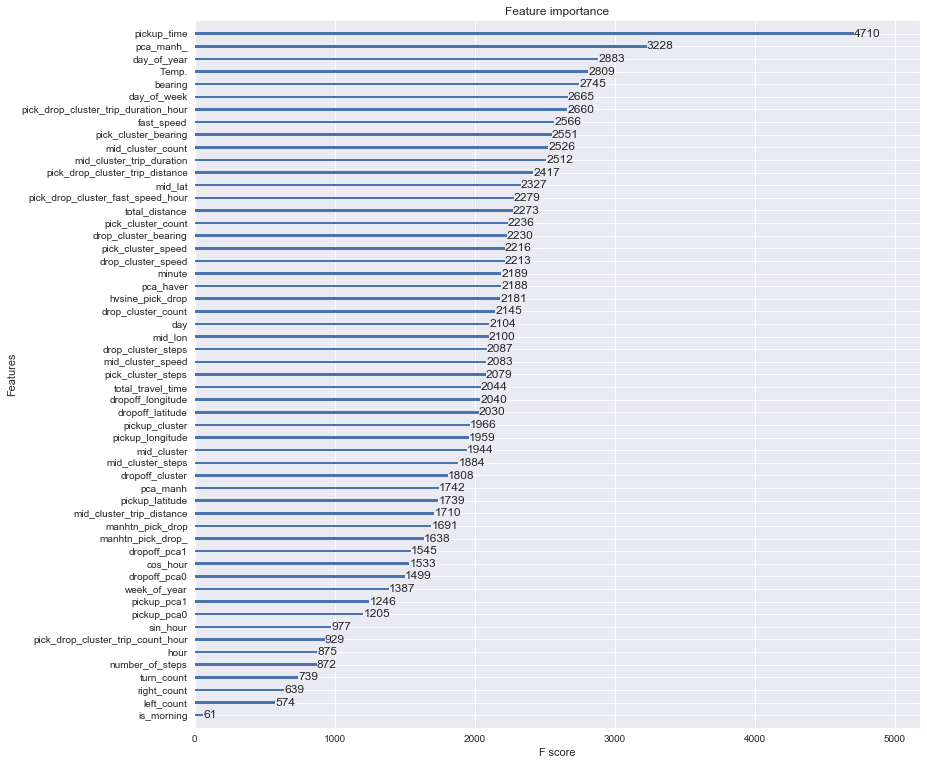

In [101]:
fig, ax = plt.subplots(figsize=(13,13))
sns.set(style='white')
xgb.plot_importance(model_3, ax=ax)
plt.show()

F-score reveals the discriminative power of each feature independently from others. One score is computed for the first feature, and another score is computed for the second feature. But it does not indicate anything on the combination of both features

In [142]:
test_df = test[test_cols]
dtest = xgb.DMatrix(test_df.values, feature_names=test_cols)
ytest = model_3.predict(dtest)

## Predict

In [144]:
# submit = pd.DataFrame()
# submit['id'] = test.id
# submit['trip_duration'] = ytest
# submit['trip_duration'] = np.exp(submit['trip_duration'])
# submit.to_csv('submission.csv', index=False)

In [141]:
# Save the model
# import pickle
# filename = 'taxi_model_whole.sav'
# pickle.dump(model_3, open(filename, 'wb'))

In [ ]:
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# loaded_model

In [ ]:
# import urllib, json
# import urllib.request
# def google(lato, lono, latd, lond):
#     url = """http://maps.googleapis.com/maps/api/distancematrix/json?origins=%s,%s"""%(lato, lono)+  \
#     """&destinations=%s,%s&mode=driving&language=en-EN&sensor=false"""% (latd, lond)
#     response = urllib.request.urlopen(url)
#     obj = json.load(response)
#     try:
#         minutes =   obj['rows'][0]['elements'][0]['duration']['value']/60
#         kilometers = (obj['rows'][0]['elements'][0]['distance']['value']/1000) #kilometers
#         return minutes, kilometers
#     except IndexError:
#         return None,None

# orig_lat = 40.767937;orig_lng = -73.982155
# dest_lat = 40.765602;dest_lng = -73.964630
# time,dist = google(orig_lat,orig_lng,dest_lat,dest_lng)
# print('It takes %1.2f min to arrive the destiny with distance %1.3f km.'%(time,dist))